In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import math
from typing import Optional
from qiskit import IBMQ
import qiskit.tools.jupyter
IBMQ.load_account()
%qiskit_backend_overview
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import transpile
from qiskit import Aer
from qiskit import assemble
import matplotlib as mpl
import numpy as np
import qiskit.extensions.quantum_initializer as qi
from qiskit.circuit.controlledgate import ControlledGate
from qiskit.circuit.gate import Gate

In [3]:
def generate_customers(n_customers):
    
    customer_id_properties=[]
    
    #np.random.seed(0)
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = round(np.random.uniform(0,4)) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table



def generate_terminals(n_terminals):
    
    #np.random.seed(0)
    terminal_id_properties=[]
    
    # Generate customer properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,120)
        y_terminal_id = np.random.uniform(0,120)
        
        #mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        #std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        #mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id
                                      #mean_amount, std_amount,
                                      #mean_nb_tx_per_day
                                      ])
        
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table



def transactions(customer_profile, terminal_profile, nb_tx):
    
    customer_transactions=[]
    
    for tx in range(nb_tx):
        
        customer_id = np.random.choice(customer_profile.CUSTOMER_ID)
        
        terminal_id = np.random.choice(terminal_profile.TERMINAL_ID)
        
        customer_transactions.append([tx, customer_id, terminal_id])
        
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX', 'CUSTOMER_ID', 'TERMINAL_ID'])
        
    return customer_transactions



def init_to_state(reg_to_init: QuantumRegister,
                  init_state: np.ndarray,
                  name: Optional[str] = None) -> Gate:
    
    # check if provided values are correct
    if len(init_state) != 2 ** len(reg_to_init):
        raise ValueError(
            "Dimensionality of the init_state does not coincide with the "
            "length of the register to initialise to: is {0} and {1}".format(
                len(init_state), len(reg_to_init)
            )
        )

    init_circ = QuantumCircuit(reg_to_init, name=name)  # create temp circuit
    init = qi.Isometry(init_state, 0, 0)  # create Isometry for init
    init_circ.append(init, reg_to_init)  # apply init to temp circuit

    basis_gates = ['u1', 'u2', 'u3', 'cx']  # list basis gates
    # transpile circuit so that it is decomposed to the basis gates above,
    #  making it unitary and possible to convert from Instruction to Gate
    transpiled = transpile(init_circ, basis_gates=basis_gates)
    init_gate = transpiled.to_gate()  # convert to Gate
    return init_gate


def controlled_initialize(reg_to_init: QuantumRegister,
                          init_state: np.ndarray,
                          num_ctrl_qubits: Optional[int] = 1,
                          order: Optional[str]=None,
                          name: Optional[str] = None) -> ControlledGate:

    
    # create the init state
    init_gate = init_to_state(reg_to_init, init_state, name)

    # make it controlled
    controlled_init = init_gate.control(num_ctrl_qubits=num_ctrl_qubits,ctrl_state=order)
    
    return controlled_init

In [4]:
n=16
p=10 #change this to increasse the number of test states
customers=generate_customers(10)
terminals=generate_terminals(20)
transactions_df = transactions(customers, terminals, n+p)


transactions_df['cos(ed)']=0
transactions_df['sin(ed)']=0
transactions_df['ed_diff']=0
transactions_df['Class']=0

    
for tx in range(len(transactions_df)):

    x_cust=customers['x_customer_id'].iloc[transactions_df['CUSTOMER_ID'].iloc[tx]]
    y_cust=customers['y_customer_id'].iloc[transactions_df['CUSTOMER_ID'].iloc[tx]]

    x_ter=terminals['x_terminal_id'].iloc[transactions_df['TERMINAL_ID'].iloc[tx]]
    y_ter=terminals['y_terminal_id'].iloc[transactions_df['TERMINAL_ID'].iloc[tx]]

    squared_diff = (x_cust-x_ter)**2 + (y_cust-y_ter)**2

    if sqrt(squared_diff) > 60:
        transactions_df['Class'].iloc[tx]=1

    transactions_df['ed_diff'].iloc[tx] = sqrt(squared_diff)
    transactions_df['cos(ed)'].iloc[tx] = math.cos(sqrt(squared_diff)/180*math.pi)
    transactions_df['sin(ed)'].iloc[tx] = math.sin(sqrt(squared_diff)/180*math.pi)


train=transactions_df.loc[0:n-1,:]

test=transactions_df.loc[n:,:]

test=test.reset_index(drop = True)


In [5]:
print(transactions_df)
print(train)
print(test)

    TX  CUSTOMER_ID  TERMINAL_ID   cos(ed)   sin(ed)     ed_diff  Class
0    0            9            8  0.749135  0.662417   41.484474      0
1    1            1            5  0.344662  0.938727   69.838811      1
2    2            6           16 -0.469638  0.882859  118.010781      1
3    3            7            1  0.965605  0.260012   15.070752      0
4    4            7            1  0.965605  0.260012   15.070752      0
5    5            5           15  0.714752  0.699378   44.377148      0
6    6            4           19  0.611878  0.790952   52.274551      0
7    7            9           17  0.882670  0.469993   28.033859      0
8    8            4            2 -0.064919  0.997891   93.722175      1
9    9            9           12  0.897622  0.440767   26.152833      0
10  10            5            0  0.496052  0.868293   60.260852      1
11  11            8            9 -0.153556  0.988140   98.833075      1
12  12            7            9  0.060056  0.998195   86.556994

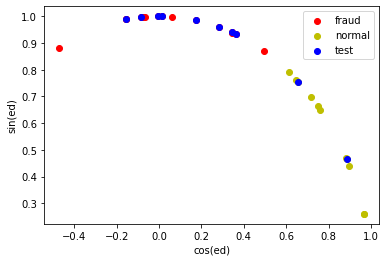

In [6]:
fraud=transactions_df.query("Class == 1")
normal=transactions_df.query("Class == 0")

plt.scatter(fraud['cos(ed)'],fraud['sin(ed)'],c='r')
plt.scatter(normal['cos(ed)'],normal['sin(ed)'],c='y')
plt.scatter(test['cos(ed)'],test['sin(ed)'],c='b')
plt.xlabel('cos(ed)')
plt.ylabel('sin(ed)')
plt.legend(['fraud','normal','test'])
plt.show()

In [8]:
train_set=[]
test_set=[]
for tx in range(len(train)):
    train_set.append([math.cos(train['ed_diff'].loc[tx]/180*math.pi),math.sin(train['ed_diff'].loc[tx]/180*math.pi)])

for tx in range(len(test)):
    test_set.append([math.cos(test['ed_diff'].loc[tx]/180*math.pi),math.sin(test['ed_diff'].loc[tx]/180*math.pi)])

# Simulator

In [9]:
fn=0
fp=0
tn=0
tp=0
accuracy3=0
for l in range(len(test_set)):

    anc = QuantumRegister(1,'anc')
    qt = QuantumRegister(1,'t')
    ql = QuantumRegister(1,'l')
    ind = QuantumRegister(4,'ind')
    cr = ClassicalRegister(5,'c')

    qc = QuantumCircuit(anc,qt,ql,ind,cr)

    qc.h(ind)
    qc.barrier()

    qc.initialize(test_set[l],qt)

    for i in range(2**len(ind)):

                a = bin(i)
                b = a[2:]
                if(len(b)!=4):
                    for j in range(4-len(b)):
                        b='0'+b
                ci = controlled_initialize(ql, train_set[i], 4 ,b)
                qc.append(ci,[6,5,4,3,2])



    qc.barrier()

    qc.h(anc)
    qc.cswap(anc,qt,ql)
    qc.h(anc)

    sim=Aer.get_backend('aer_simulator')
    qc.save_statevector()

    qc.measure(ind[3],cr[0])
    qc.measure(ind[2],cr[1])
    qc.measure(ind[1],cr[2])
    qc.measure(ind[0],cr[3])
    qc.measure(anc,cr[4])

    tes = transpile(qc, sim)
    qobj = assemble(tes)

    job = sim.run(qobj,shots = 1024)
    hist=job.result().get_counts()

    from qiskit.visualization import plot_histogram
    plot_histogram(hist)

    qc.draw('mpl')

    results = pd.DataFrame(hist, index=[0])

    instance_0 = 0
    instance_1 = 0
    for i in results.columns:
        if(i[0]=='0'):
            instance_0 = instance_0 + int(results[i])
        else:
            instance_1 = instance_1 + int(results[i])

    total = instance_0+instance_1
    prob_0 = instance_0/total
    mean_fidelity = 2 * ( prob_0 - 1/2 )


    diff_p0_p1=[]
    occurency=[]
    for i in results.columns:
        for j in results.columns:
            if( i != j and i[1:] == j[1:]):

                if ( i[0]=='0' and j[0]=='1'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)
                    occurency.append(i)

                elif ( i[0]=='1' and i[0]=='0'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)

    df = pd.DataFrame(diff_p0_p1,occurency)
    df.columns = ['diff_p0_p1 q(i)']
    

    Q_3NN=df.nlargest(3, ['diff_p0_p1 q(i)'])    
    Q_3NN['Class']=0
    for i in Q_3NN.index:
        a = len(i[1:])
        b = i[1:]
        s=0
        for j in range(a):

            #print(b[j])
            s=s+int(b[j])*2**(a-(j+1))
        Q_3NN['Class'].loc[i]=transactions_df['Class'].loc[s]


    cl0=0
    cl1=0
    #print(Q_3NN)
    for i in Q_3NN['Class']:
        if( i == 0 ):
            cl0 = cl0 +1
            #print('N')
        else:
            cl1 = cl1 +1
            #print('F')
    #print(cl0,cl1)
    if(cl0 > cl1):
        print('Test state ',l,' is NORMAL-3NN')
        t=0
    else:
        print('Test state ',l,' is FRAUDULENT-3NN')
        t=1
        
#print(transactions_df)
    if(int(test['Class'].iloc[l])==t):
            accuracy3=accuracy3+1

    if(int(test['Class'].iloc[l])==0 and t==1):
        fp=fp+1
    elif(int(test['Class'].iloc[l])==1 and t==0):
        fn=fn+1
    elif(int(test['Class'].iloc[l])==0 and t==0):
        tn=tn+1
    elif(int(test['Class'].iloc[l])==1 and t==1):
        tp=tp+1



    

print('False positive: ',fp)
print('False negative: ',fn)
print('True positive: ',tp)
print('True negative: ',tn)
print('Accuracy-3NN: ',accuracy3/p*100,'%')

Test state  0  is NORMAL-3NN
Test state  1  is NORMAL-3NN
Test state  2  is FRAUDULENT-3NN
Test state  3  is FRAUDULENT-3NN
Test state  4  is FRAUDULENT-3NN
Test state  5  is NORMAL-3NN
Test state  6  is FRAUDULENT-3NN
Test state  7  is NORMAL-3NN
Test state  8  is FRAUDULENT-3NN
Test state  9  is FRAUDULENT-3NN
False positive:  0
False negative:  2
True positive:  6
True negative:  2
Accuracy-3NN:  80.0 %


# IBM - Nairobi

In [ ]:
fn=0
fp=0
tn=0
tp=0
accuracy3=0
for l in range(len(test_set)):

    anc = QuantumRegister(1,'anc')
    qt = QuantumRegister(1,'t')
    ql = QuantumRegister(1,'l')
    ind = QuantumRegister(4,'ind')
    cr = ClassicalRegister(5,'c')

    qc = QuantumCircuit(anc,qt,ql,ind,cr)

    qc.h(ind)
    qc.barrier()

    qc.initialize(test_set[l],qt)

    for i in range(2**len(ind)):

                a = bin(i)
                b = a[2:]
                if(len(b)!=4):
                    for j in range(4-len(b)):
                        b='0'+b
                ci = controlled_initialize(ql, train_set[i], 4 ,b)
                qc.append(ci,[6,5,4,3,2])



    qc.barrier()

    qc.h(anc)
    qc.cswap(anc,qt,ql)
    qc.h(anc)

    provider = IBMQ.get_provider(hub='ibm-q')
    sim = provider.get_backend('ibm_nairobi')

    qc.measure(ind[3],cr[0])
    qc.measure(ind[2],cr[1])
    qc.measure(ind[1],cr[2])
    qc.measure(ind[0],cr[3])
    qc.measure(anc,cr[4])

    tes = transpile(qc, sim)
    qobj = assemble(tes)

    job = sim.run(qobj,shots = 1024)
    hist=job.result().get_counts()

    from qiskit.visualization import plot_histogram
    plot_histogram(hist)

    qc.draw('mpl')

    results = pd.DataFrame(hist, index=[0])

    instance_0 = 0
    instance_1 = 0
    for i in results.columns:
        if(i[0]=='0'):
            instance_0 = instance_0 + int(results[i])
        else:
            instance_1 = instance_1 + int(results[i])

    total = instance_0+instance_1
    prob_0 = instance_0/total
    mean_fidelity = 2 * ( prob_0 - 1/2 )


    diff_p0_p1=[]
    occurency=[]
    for i in results.columns:
        for j in results.columns:
            if( i != j and i[1:] == j[1:]):

                if ( i[0]=='0' and j[0]=='1'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)
                    occurency.append(i)

                elif ( i[0]=='1' and i[0]=='0'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)

    df = pd.DataFrame(diff_p0_p1,occurency)
    df.columns = ['diff_p0_p1 q(i)']
    

    Q_3NN=df.nlargest(3, ['diff_p0_p1 q(i)'])    
    Q_3NN['Class']=0
    for i in Q_3NN.index:
        a = len(i[1:])
        b = i[1:]
        s=0
        for j in range(a):

            #print(b[j])
            s=s+int(b[j])*2**(a-(j+1))
        Q_3NN['Class'].loc[i]=transactions_df['Class'].loc[s]


    cl0=0
    cl1=0
    #print(Q_3NN)
    for i in Q_3NN['Class']:
        if( i == 0 ):
            cl0 = cl0 +1
            #print('N')
        else:
            cl1 = cl1 +1
            #print('F')
    #print(cl0,cl1)
    if(cl0 > cl1):
        print('Test state ',l,' is NORMAL-3NN')
        t=0
    else:
        print('Test state ',l,' is FRAUDULENT-3NN')
        t=1
        
#print(transactions_df)
    if(int(test['Class'].iloc[l])==t):
            accuracy3=accuracy3+1

    if(int(test['Class'].iloc[l])==0 and t==1):
        fp=fp+1
    elif(int(test['Class'].iloc[l])==1 and t==0):
        fn=fn+1
    elif(int(test['Class'].iloc[l])==0 and t==0):
        tn=tn+1
    elif(int(test['Class'].iloc[l])==1 and t==1):
        tp=tp+1



    

print('False positive: ',fp)
print('False negative: ',fn)
print('True positive: ',tp)
print('True negative: ',tn)
print('Accuracy-3NN: ',accuracy3/p*100,'%')

# IBM-Oslo

In [ ]:
fn=0
fp=0
tn=0
tp=0
accuracy3=0
for l in range(len(test_set)):

    anc = QuantumRegister(1,'anc')
    qt = QuantumRegister(1,'t')
    ql = QuantumRegister(1,'l')
    ind = QuantumRegister(4,'ind')
    cr = ClassicalRegister(5,'c')

    qc = QuantumCircuit(anc,qt,ql,ind,cr)

    qc.h(ind)
    qc.barrier()

    qc.initialize(test_set[l],qt)

    for i in range(2**len(ind)):

                a = bin(i)
                b = a[2:]
                if(len(b)!=4):
                    for j in range(4-len(b)):
                        b='0'+b
                ci = controlled_initialize(ql, train_set[i], 4 ,b)
                qc.append(ci,[6,5,4,3,2])



    qc.barrier()

    qc.h(anc)
    qc.cswap(anc,qt,ql)
    qc.h(anc)

    provider = IBMQ.get_provider(hub='ibm-q')
    sim = provider.get_backend('ibm_oslo')

    qc.measure(ind[3],cr[0])
    qc.measure(ind[2],cr[1])
    qc.measure(ind[1],cr[2])
    qc.measure(ind[0],cr[3])
    qc.measure(anc,cr[4])

    tes = transpile(qc, sim)
    qobj = assemble(tes)

    job = sim.run(qobj,shots = 1024)
    hist=job.result().get_counts()

    from qiskit.visualization import plot_histogram
    plot_histogram(hist)

    qc.draw('mpl')

    results = pd.DataFrame(hist, index=[0])

    instance_0 = 0
    instance_1 = 0
    for i in results.columns:
        if(i[0]=='0'):
            instance_0 = instance_0 + int(results[i])
        else:
            instance_1 = instance_1 + int(results[i])

    total = instance_0+instance_1
    prob_0 = instance_0/total
    mean_fidelity = 2 * ( prob_0 - 1/2 )


    diff_p0_p1=[]
    occurency=[]
    for i in results.columns:
        for j in results.columns:
            if( i != j and i[1:] == j[1:]):

                if ( i[0]=='0' and j[0]=='1'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)
                    occurency.append(i)

                elif ( i[0]=='1' and i[0]=='0'):

                    diff_p0_p1.append(float(int(results[i])-int(results[j]))/total)

    df = pd.DataFrame(diff_p0_p1,occurency)
    df.columns = ['diff_p0_p1 q(i)']
    

    Q_3NN=df.nlargest(3, ['diff_p0_p1 q(i)'])    
    Q_3NN['Class']=0
    for i in Q_3NN.index:
        a = len(i[1:])
        b = i[1:]
        s=0
        for j in range(a):

            #print(b[j])
            s=s+int(b[j])*2**(a-(j+1))
        Q_3NN['Class'].loc[i]=transactions_df['Class'].loc[s]


    cl0=0
    cl1=0
    #print(Q_3NN)
    for i in Q_3NN['Class']:
        if( i == 0 ):
            cl0 = cl0 +1
            #print('N')
        else:
            cl1 = cl1 +1
            #print('F')
    #print(cl0,cl1)
    if(cl0 > cl1):
        print('Test state ',l,' is NORMAL-3NN')
        t=0
    else:
        print('Test state ',l,' is FRAUDULENT-3NN')
        t=1
        
#print(transactions_df)
    if(int(test['Class'].iloc[l])==t):
            accuracy3=accuracy3+1

    if(int(test['Class'].iloc[l])==0 and t==1):
        fp=fp+1
    elif(int(test['Class'].iloc[l])==1 and t==0):
        fn=fn+1
    elif(int(test['Class'].iloc[l])==0 and t==0):
        tn=tn+1
    elif(int(test['Class'].iloc[l])==1 and t==1):
        tp=tp+1



    

print('False positive: ',fp)
print('False negative: ',fn)
print('True positive: ',tp)
print('True negative: ',tn)
print('Accuracy-3NN: ',accuracy3/p*100,'%')